# `Материалы кафедры ММП факультета ВМК МГУ. Введение в глубокое обучение.`

## `Задание 3.5. Трансформеры для Named Entity Recognition`

#### Фамилия, имя: Загатин Даниил

Дата выдачи: <span style="color:red">__27 марта 23:59__</span>.

Мягкий дедлайн: <span style="color:red">__06 апреля 05:00__</span>.

Стоимость: __10 баллов__ (основная часть заданий)

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2025`

В рамках этого задания вы научитесь:
1. Загружать датасеты и претренированные модели из [Hugging face Hub](https://huggingface.co)
2. Манипулировать текстовыми датасетами с помощью библиотеки [datasets](https://huggingface.co/docs/datasets/index)
3. Запускать и обучать трансформеры с помощью библиотеки [transformers](https://huggingface.co/docs/transformers/index)
4. Промптить большую языковую модель на примере [Qwen2.5-7B-Instruct](https://huggingface.co/Qwen/Qwen2.5-7B-Instruct)
5. Оптимизировать гиперпараметры с помощью библиотеки [optuna](https://optuna.org/)

При выполнении задания вы будете решать стандартную задачу классификации токенов: распознавание именованных сущностей.

Задание состоит из трёх частей:
1. Обработка данных и работа с датасетами из Hugging Face.
2. Практика больших языковых моделей.
3. Дообучение трансформера.

Обратите свое внимание на [официальный гайд](https://huggingface.co/learn/nlp-course/chapter7/2), в котором подробно разбирается задача классификации токенов.

## `Часть 1. Загрузка и предобработка (4 балла)`

### `Подготовка среды Kaggle`

**Хранение ключей**: Kaggle Secrets --- инструмент для безопасного хранения и использования в ноутбуках Kaggle API-ключей, паролей или токенов.

Для добавления нового ключа:
1. Перейдите в Add-ons --> secrets
2. Add secret для добавления нового ключа. Доступ к ключу из ноутбука осуществляется с помощью пакета kaggle_secrets
3. Коллекция ключей общая для всех ноутбуков пользователя на kaggle. Но в каждом ноутбуке необходимо выбрать ключи, которые будут доступны через kaggle_secrets

Ниже находится пример подгрузки ключей для kaggle и wandb.

In [ ]:
# from kaggle_secrets import UserSecretsClient
# import os

# api_keys = UserSecretsClient()

# os.system(f"huggingface-cli login --token {api_keys.get_secret('HF_TOKEN')}")
# os.system(f"wandb login {api_keys.get_secret('wandb')}")

**Установка домашнего каталога**: Если мы хотим контролировать путь, по которому будут загружаться датасеты, чекпоинты моделей и т.д., то стоит задать переменную среды `HF_HOME`. При использовании kaggle перемещение домашнего каталога huggingface в директорию working позволит избежать повторной загрузки при перезапуске ноутбука (не забудьте установить "persistence: files only" в настройках kaggle-ноутбука)

In [ ]:
# Optional

# os.environ['HF_HOME'] = '/kaggle/working/hf_hub'

### `Подготовка среды Google Colab`

Секреты можно настроить в колабе:

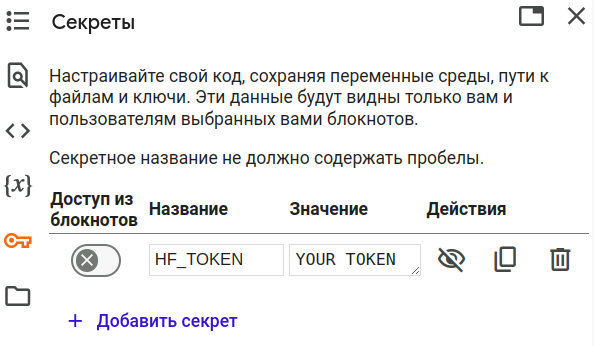

In [ ]:
# import os
# from google.colab import userdata
# userdata.get('secretName')

# os.system(f"huggingface-cli login --token {api_keys.get_secret('huggingface-cli')}")
# os.system(f"wandb login {api_keys.get_secret('wandb')}")

### `Общая подготовка`

In [1]:
# pip offers the --quiet / -q option to silence output

! pip install transformers[torch] datasets autoawq evaluate seqeval optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

При работе с библиотеками часто бывает важно соблюдение версий. Задание тестировалось на Python 3.12 при версиях библиотек указанных ниже.

In [2]:
!pip freeze > requirements.txt
!cat requirements.txt | grep torch

torch @ https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl
torchaudio @ https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl
torchsummary==1.5.1
torchvision @ https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp311-cp311-linux_x86_64.whl


In [3]:
!cat requirements.txt | grep transformers
!cat requirements.txt | grep datasets
!cat requirements.txt | grep autoawq
!cat requirements.txt | grep evaluate
!cat requirements.txt | grep seqeval
!cat requirements.txt | grep optuna

sentence-transformers==3.4.1
transformers==4.50.3
datasets==3.5.0
tensorflow-datasets==4.9.8
vega-datasets==0.9.0
autoawq==0.2.7.post3
evaluate==0.4.3
seqeval==1.2.2
optuna==4.2.1


In [4]:
import gc
import json
import random
from typing import Any, Union
from pathlib import Path

import numpy as np
import numpy.typing as npt

import torch
import datasets
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TextGenerationPipeline,
    pipeline,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer
)
from transformers.trainer_callback import EarlyStoppingCallback

import optuna
import evaluate

torch.backends.cudnn.benchmark = True
torch.use_deterministic_algorithms(False)

torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.autograd.set_detect_anomaly(False)

torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.allow_tf32 = True

In [5]:
def set_global_seed(seed: int) -> None:
    """Set global seed for reproducibility.
    :param int seed: Seed to be set
    """
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def print_params_count(model):

    total_params = sum(p.numel() for p in model.parameters())
    total_params_grad = sum(p.numel() for p in model.parameters() if p.requires_grad)

    model_name = model.__class__.__name__
    print(f"Информация о числе параметров модели: {model_name}")
    print(f"Всего параметров: \t\t {total_params}")
    print(f"Всего обучаемых параметров: \t {total_params_grad}")
    print()

set_global_seed(42)

На протяжении всего задания вы можете добавлять любой `import`, иногда, это и являются частью задания. При работе с большими библиотеками очень важно уметь читать документацию и использовать гугл для поиска информации.

Для выполнения задания необходимо использование GPU!

In [6]:
if not torch.cuda.is_available():
    print("You need GPU!!!")

### `Загрузка данных (0.25 балла)`

В первую очередь, Hugging Face --- это хаб с датасетами и моделями. Загрузите готовый датасет [отсюда](https://huggingface.co/datasets/voorhs/conll2003-corrupted).

Подсказка: почитайте [туториал](https://huggingface.co/docs/datasets/load_hub).

*Если не получится сразу, то лучше перед следующими попытками перезапустить ноутбук.*

In [7]:
# YOUR CODE IS HERE
from datasets import load_dataset

dataset_raw_essential = load_dataset("voorhs/conll2003-corrupted")

README.md:   0%|          | 0.00/2.28k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/309k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/281k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

**Вопрос**: Какие поля нам доступны? Напечатайте пару примеров из каждого сплита. Попытайтесь догадаться какой смысл имеет каждое поле и опишите в двух словах.

*Подсказка:* почитайте [туториал](https://huggingface.co/docs/datasets/access).

In [8]:
# YOUR CODE IS HERE
for data in (["train", "test", "validation"]):
    print(data)
    print(dataset_raw_essential[data][0])
    print(dataset_raw_essential[data][1])


train
{'id': '473', 'tokens': ['LONDON', '1996-08-22'], 'pos_tags': [22, 11], 'chunk_tags': [11, 12], 'ner_tags': ['B-LOC', 'O']}
{'id': '8848', 'tokens': ['WorldCom', ',', 'which', 'said', 'it', 'will', 'buy', 'MFS', ',', 'shed', '1-3/4', 'to', 'close', 'at', '21', 'while', 'MFS', 'lost', '3-8/16', 'to', 'close', 'at', '41-5/16', '.'], 'pos_tags': [21, 6, 43, 38, 28, 20, 37, 22, 6, 38, 11, 35, 37, 15, 11, 15, 22, 38, 11, 35, 37, 15, 11, 7], 'chunk_tags': [11, 0, 11, 21, 11, 21, 22, 11, 0, 21, 11, 21, 22, 13, 11, 17, 11, 21, 22, 22, 22, 13, 3, 0], 'ner_tags': ['B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}
test
{'id': '0', 'tokens': ['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'CHINA', 'IN', 'SURPRISE', 'DEFEAT', '.'], 'pos_tags': [21, 8, 22, 37, 22, 22, 6, 22, 15, 12, 21, 7], 'chunk_tags': [11, 0, 11, 21, 11, 12, 0, 11, 13, 11, 12, 0], 'ner_tags': ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PE

In [9]:
dataset_raw_essential

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

**Ответ:** id - номер предложения. tokens - Список токенов в тексте. pos_tags - Часть речи для каждого токена, представлена числовыми метками. chunk_tags - теги для группировки токенов. ner_tags - теги для распознавания именованных сущностей.

### `Удаление колонок (0.25 балла)`

Мы будем предсказывать NER tags непосредственно по тексту. Остальная информация нам не понадобится. Удалите все колонки кроме `tokens` и `ner_tags`.

*Подсказка:* почитайте [туториал](https://huggingface.co/docs/datasets/process#remove).

In [10]:
# YOUR CODE IS HERE
dataset_raw_essential["train"] = dataset_raw_essential["train"].remove_columns(['id', 'pos_tags', 'chunk_tags'])
dataset_raw_essential["test"] = dataset_raw_essential["test"].remove_columns(['id', 'pos_tags', 'chunk_tags'])
dataset_raw_essential["validation"] = dataset_raw_essential["validation"].remove_columns(['id', 'pos_tags', 'chunk_tags'])

In [11]:
dataset_raw_essential

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3453
    })
})

### `Сбор тегов (0.25 балла)`

Обратите внимание,что в датасете представлена **BIO-разметка**.

**BIO-разметка** -- это способ аннотации текста для распознавания именованных сущностей (NER), где **B** (Beginning) обозначает начало сущности, **I** (Inside) — продолжение той же сущности, а **O** (Outside) — отсутствие сущности.

Например, в предложении *"Apple выпустила новый iPhone"* разметка будет: *"Apple/B-ORG выпустила/O новый/O iPhone/B-PRODUCT"*.

В предложении  *"Билл Гейтс основал Microsoft"* -- *"Билл/B-PER Гейтс/I-PER основал/O Microsoft/B-ORG"*.

**Такой формат помогает моделям точно определять границы и типы сущностей.**



Прежде чем работать с датасетом, необходимо понять, какие именно NER-теги присутствуют в данных. Напечатайте все уникальные значения NER-тегов, которые встречаются в датасете.

*Подсказка:* по датасету можно итерироваться с помощью конструкции `for ... in`

**Вопрос:**
- есть ли какие-то подозрительные теги, которых быть не должно?

In [12]:
# YOUR CODE IS HERE
uniq_tags = set()
for split in dataset_raw_essential.values():
    for elem in split:
        uniq_tags.update(elem["ner_tags"])

uniq_tags


{'B-LOC',
 'B-MISC',
 'B-ORG',
 'B-PER',
 'I-LOC',
 'I-MISC',
 'I-ORG',
 'I-PER',
 'MISSING',
 'O'}

Да, есть подозрительный MISSING, который сигналиризирует о не размеченной выборкею

Для вычисления лосс функции и подсчета метрик нам потребуется перевести теги в классы, так как мы будем решать задачу классификации.

Создайте мапинги тегов:
- `label2id`: строковое представление тега (например `B-PER`) -> индекс класса
- `id2label`: наоборот

Исключите из них подозрительные теги, которых не должно быть.

*Подсказка:* должно получиться 9 тегов

In [13]:
# YOUR CODE IS HERE
id2label = sorted(uniq_tags - {'MISSING'})
id2label

['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

In [14]:
label2id = {name: i for i, name in enumerate(id2label)}
label2id

{'B-LOC': 0,
 'B-MISC': 1,
 'B-ORG': 2,
 'B-PER': 3,
 'I-LOC': 4,
 'I-MISC': 5,
 'I-ORG': 6,
 'I-PER': 7,
 'O': 8}

### `Фильтрация (0.25 балла)`

В обучающей выборке для части объектов пропущена разметка. Разделите обучающую выборку на размеченные и неразмеченные объекты. Напечатайте размеры обеих частей.

*Подсказка:* прочитайте [туториал](https://huggingface.co/docs/datasets/process#select-and-filter). Фильрацию датасета можно написать в одну строчку.

In [15]:
# YOUR CODE IS HERE
dataset_raw_essential["train_missing"] = dataset_raw_essential["train"].filter(lambda example: all(tag == "MISSING" for tag in example["ner_tags"]))
dataset_raw_essential["train"] = dataset_raw_essential["train"].filter(lambda example: any(tag != "MISSING" for tag in example["ner_tags"]))

dataset_raw_essential

Filter:   0%|          | 0/14041 [00:00<?, ? examples/s]

Filter:   0%|          | 0/14041 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 4041
    })
})

In [16]:
assert len(dataset_raw_essential["train_missing"]) == 4041

### `Получение tokenizer-independent представления (2 балла)`

Имеющаяся BIO-разметка построена для токенизатора, который нам, к сожалению, **не известен**. Необходимо построить tokenizer-independent представление нашего датасета.

**Восстановление текста**: Для каждого объекта датасета необходимо объединить токены из `tokens` в единую строку и поместить в поле `text`. Необходимо учесть, что знаки препинания, кавычки и скобки (например, `,`, `.`, `!`. `)`, `"`) не должны иметь пробелов перед собой, но должны иметь пробел после себя.

**Изменение BIO-разметки**: Так как каждый токенизатор по-своему разобьет полученный `text`, то необходимо уметь строить BIO-разметку для любого токенизатора.

По имеющейся BIO-разметке необходимо:
* Оставить только последовательность сущностей, удалив префиксы начала (B- и I-).
* Для каждой именованной сущности найти позиции символов, ей соответствующие (в формате python slice).

Пример результата:
```python
{
    'text': '6 - Andre Agassi (U.S.) vs. Mauricio Hadad (Colombia)',
    'tags': ['PER', 'LOC', 'PER','LOC'],
    'ranges': [[4, 16], [19, 23], [30, 44], [47, 55]]
}
```

*Пояснение к примеру*. В тексте `'6 - Andre Agassi (U.S.) vs. Mauricio Hadad (Colombia)'` встретилось четыре сущности:
- `PER` на позициях `[4,16]`, а именно `Andre Agassi`
- `LOC` на позициях `[19,23]`, а именно `U.S.`
- `PER` на позициях `[30,44]`, а именно `Mauricio Hadad`
- `LOC` на позициях `[47,55]`, а именно `Colombia`

**Важно:**
- Полученный результат сохраните на диск (например по пути `./data/generic`)
- Подробности о названиях аргументов и возвращаемых значениях берите из докстринга функции `transform_ner_data`

In [17]:
def transform_ner_data(tokens: list[str], ner_tags: list[str]):
    """
    Obtain tokenizer-independent representation of a single sample.

    Args:
        tokens: list of words, subwords or even punctuations
        ner_tags: list of BIO labels
    Returns:
        sample: dictionary with the following contents:
            - text (str): detokenized sequence
            - tags (list[str]): list of tags names (PER, ORG, LOC, MISC)
            - ranges (list[tuple[int, int]]): list of python slices for each entity
    """

    punctuation_symbols = ("-", "'", ".", ",", ")", ":", ";", '"')

    text = ""
    ranges = []
    tags = []

    # declare vars if you needed
    # YOUR CODE IS HERE
    obj_start = None
    need_add_flag = False
    prev_token_end = 0

    for token, tag in zip(tokens, ner_tags):
        # Adjust spacing based on token type
        if len(text) > 0 and not token.startswith(
            punctuation_symbols
        ):
            text += " "

        token_start = len(text)
        text += token
        token_end = len(text)

        # Handle entity tagging
        if tag.startswith("B-"):  # Begin a new entity
            # Close the previous entity
            # YOUR CODE IS HERE
            if obj_start is not None and need_add_flag:
                ranges.append((obj_start, prev_token_end))
                need_add_flag = False
            obj_start = token_start
            tags.append(tag[2:])
            need_add_flag = True


        elif tag.startswith("I-"):  # Continue an entity
            # YOUR CODE IS HERE
            pass


        else:  # Tag is "O" or unrelated, close any open entity
            # YOUR CODE IS HERE
            if obj_start is not None and need_add_flag:
                ranges.append((obj_start, prev_token_end))
                need_add_flag = False
        prev_token_end = token_end
    # Close any open entity at the end
    # YOUR CODE IS HERE
    if obj_start is not None and need_add_flag:
        ranges.append((obj_start, prev_token_end))
        need_add_flag = False

    # Final output
    return {"text": text, "tags": tags, "ranges": ranges}

Проверьте, что все работает:

In [18]:
dataset_generic = dataset_raw_essential.map(
    function=transform_ner_data,
    input_columns=["tokens", "ner_tags"],
    remove_columns=dataset_raw_essential["train"].column_names,
)

dataset_generic

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/4041 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 4041
    })
})

In [19]:
assert dataset_generic["train"][:3] == {
    "text": [
        "LONDON 1996-08-22",
        "WorldCom, which said it will buy MFS, shed 1-3/4 to close at 21 while MFS lost 3-8/16 to close at 41-5/16.",
        "6- Andre Agassi ( U.S.) vs. Mauricio Hadad ( Colombia)",
    ],
    "tags": [["LOC"], ["ORG", "ORG", "ORG"], ["PER", "LOC", "PER", "LOC"]],
    "ranges": [
        [[0, 6]],
        [[0, 8], [33, 36], [70, 73]],
        [[3, 15], [18, 22], [28, 42], [45, 53]],
    ],
}

Сохраните результат на диск (используйте функции из библиотеки `datasets`):

In [20]:
# YOUR CODE IS HERE
dataset_generic.save_to_disk("generic")

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3250 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3453 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4041 [00:00<?, ? examples/s]

### `Токенизация (1 балл)`

Для отладки воспользуемся токенизатором модели `google-bert/bert-base-uncased`.

In [21]:
from transformers import AutoTokenizer

bert_tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [22]:
print(bert_tokenizer(dataset_generic["train"]["text"][11]))

{'input_ids': [101, 3078, 3707, 6434, 2001, 27502, 1010, 6352, 11000, 1010, 2403, 1012, 1019, 3867, 2062, 2084, 2197, 2251, 1998, 1014, 1012, 1015, 3867, 2062, 2084, 1999, 2238, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


У каждого токенизатора есть свои специальные токены, для получения этой информации можно воспользоваться соотвествующей переменной.

In [23]:
bert_tokenizer.all_special_ids

[100, 102, 0, 101, 103]

Теперь надо написать функцию, которая по имеющуемуся tokenizer-independent представлению выдает BIO-разметку для предоставленного токенизатора.  Реализуйте функцию `align_tokens_and_tags`, которая трансформирует один объект из датасета. Все подробности о формате входных данных берите из докстринга.

**Важно:** служебные токены, добавляемые токенизатором должны иметь специальный лейбл `SPECIAL_TOKENS_LABEL`, т.к. их не надо учитывать при сборе лосса.

In [24]:
SPECIAL_TOKENS_LABEL = -100


def align_tokens_and_tags(
    text: str, tags: list[str], ranges: list[tuple[int, int]], tokenizer: AutoTokenizer
):
    """
    Align the tokenizer-independent representation with a Hugging Face tokenizer.

    Args:
        text: original text.
        tags: list of entity tags (e.g., ["PER", "LOC"]).
        ranges: list of (start, end) character ranges for each entity.
        tokenizer: A Hugging Face tokenizer.

    Returns:
        dict: A dictionary with `input_ids`, `labels`:
            - input_ids are tokens indices in tokenizer's vocabulary
            - labels are integer labels for BIO tags (from label2id mapping)

    Note:
        This function
    """
    encoding = tokenizer(
        text, return_offsets_mapping=True, truncation=True, padding=False
    )
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"])
    token_ids = encoding["input_ids"]
    offset_mapping = encoding["offset_mapping"]


    # Initialize BIO tags for each token
    # YOUR CODE IS HERE
    bio_labels = []

    for start, end in offset_mapping:
        if start == end:
            bio_labels.append(SPECIAL_TOKENS_LABEL)
        else:
            bio_labels.append(label2id["O"])

    # Map character ranges to token indices
    for tag, (start, end) in zip(tags, ranges):
        entity_started = False

        label = label2id["O"]
        # Find tokens that overlap with the entity range
        for (i, (token_start, token_end)), token_id in zip(
            enumerate(offset_mapping), token_ids
        ):

            # detect no overlap
            # YOUR CODE IS HERE
            if token_end <= start or token_start >= end:
                continue

            # classifier token
            #     hint: use if
            # YOUR CODE IS HERE
            if token_start == token_end:
                continue

            if not entity_started:
                bio_labels[i] = label2id["B-" + tag]
                entity_started = True
            else:
                bio_labels[i] = label2id["I-" + tag]


    return {
        "input_ids": token_ids,
        "labels": bio_labels # don't forget to handle special tokens
    }

In [25]:
def tokenize_ner_dataset(
    dataset: Union[datasets.DatasetDict, datasets.Dataset], tokenizer: AutoTokenizer
):
    return dataset.map(
        function=align_tokens_and_tags,
        input_columns=["text", "tags", "ranges"],
        fn_kwargs={"tokenizer": tokenizer},
        remove_columns=(
            dataset["train"] if "train" in dataset else dataset
        ).column_names,
    )

Вот пара примеров того, что должно получиться:

In [26]:
for i in range(9, 12):
    sample = dataset_generic["train"][i]
    print("before tokenization:", sample)
    tokenized_sample = align_tokens_and_tags(**sample, tokenizer=bert_tokenizer)
    print("after tokenization:", tokenized_sample)
    print()

before tokenization: {'text': '1-0.', 'tags': [], 'ranges': []}
after tokenization: {'input_ids': [101, 1015, 1011, 1014, 1012, 102], 'labels': [-100, 8, 8, 8, 8, -100]}

before tokenization: {'text': 'Puchon 3 Chonan 0 ( halftime 1-0)', 'tags': ['ORG', 'ORG'], 'ranges': [[0, 6], [9, 15]]}
after tokenization: {'input_ids': [101, 16405, 24561, 1017, 16480, 7229, 1014, 1006, 22589, 1015, 1011, 1014, 1007, 102], 'labels': [-100, 2, 6, 8, 2, 6, 8, 8, 8, 8, 8, 8, 8, -100]}

before tokenization: {'text': 'Primary iron output was 297,700 tonnes, 14.5 percent more than last July and 0.1 percent more than in June.', 'tags': [], 'ranges': []}
after tokenization: {'input_ids': [101, 3078, 3707, 6434, 2001, 27502, 1010, 6352, 11000, 1010, 2403, 1012, 1019, 3867, 2062, 2084, 2197, 2251, 1998, 1014, 1012, 1015, 3867, 2062, 2084, 1999, 2238, 1012, 102], 'labels': [-100, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, -100]}



Тесты:

In [27]:
dataset_tokenized = tokenize_ner_dataset(dataset_generic, bert_tokenizer)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/4041 [00:00<?, ? examples/s]

In [28]:
assert dataset_tokenized["train"][5:7] == {
    "input_ids": [
        [
            101,
            2002,
            2596,
            2000,
            2031,
            2042,
            2730,
            2006,
            9857,
            2305,
            1010,
            6114,
            2012,
            2560,
            2809,
            17079,
            8710,
            1012,
            102,
        ],
        [
            101,
            1023,
            1012,
            13093,
            6178,
            25185,
            1006,
            5706,
            1007,
            8902,
            4877,
            13181,
            2361,
            3590,
            102,
        ],
    ],
    "labels": [
        [-100, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, -100],
        [-100, 8, 8, 3, 7, 7, 8, 0, 8, 2, 6, 6, 6, 8, -100],
    ],
}

## `Часть 2. Доразметка с помощью LLM (2 балла)`

Наконец, обратимся к трансфомерам! Причем сразу к большим.

Мы воспользуемся моделью `Qwen2.5` на 7 миллиардов параметров. Посмотреть актуальный лидерборд различных LLM [можно тут](https://lmarena.ai/). Кроме того, во вкладке direct chat можно пообщаться с различными LLM бесплатно.

### `Промт инжиниринг`

Для удобства парсинга, мы будем просить LLM возвращать ответы сразу в формате `json` словаря.

Напишите промт, в котором перечислите и опишите поля словаря, которые вы хотите получать от LLM.

**Важно:** скорее всего, вы будете возвращаться к этому заданию и редактировать промт, чтобы улучшить качество дальшейших шагов.

*Подсказка:* попросите LLM добавить в словарь отдельное поле `reasoning`, в которую она поместит рассуждения

In [29]:
def messages_maker(text: str) -> list[dict[str, str]]:
    """
    Creates a prompt for the LLM inference to generate NER labels.

    Args:
        text: The input text to be labeled.
    Returns:
        list: A list of messages formatted for the LLM inferemce.
    """
    system_message = (
        "You are an expert in Named Entity Recognition (NER). Your task is to analyze the given text and identify "
        "entities such as persons (PER), locations (LOC), organizations (ORG), and miscellaneous (MISC). "
        "You must return the results in a specific JSON format with the following fields: "
        "The 'reasoning' field should contain all your initial thoughts for solving NER task. "
         "You must return the results in the following strict JSON format:\n\n"
        "- reasoning (str): Explanation of how you determined the entities and their types.\n"
        "- text (str): The original input text.\n"
        "- tags (list[str]): List of entity labels for each entity found.\n"
        "- ranges (list[list[int]]): Start and end character positions [start, end) for each entity.\n\n"
        "Return only a JSON object and nothing else.\n\n"
        "Examples:\n\n"
        "{\n"
        '  "reasoning": "LONDON is a city (LOC). WorldCom and MFS are company names (ORG). Andre Agassi and Mauricio Hadad are persons (PER), and U.S. and Colombia are countries (LOC).",\n'
        '  "text": "LONDON 1996-08-22",\n'
        '  "tags": ["LOC"],\n'
        '  "ranges": [[0, 6]]\n'
        "},\n"
        "{\n"
        '  "reasoning": "WorldCom and MFS are both organizations, mentioned in a financial context.",\n'
        '  "text": "WorldCom, which said it will buy MFS, shed 1-3/4 to close at 21 while MFS lost 3-8/16 to close at 41-5/16.",\n'
        '  "tags": ["ORG", "ORG", "ORG"],\n'
        '  "ranges": [[0, 8], [33, 36], [70, 73]]\n'
        "},\n"
        "{\n"
        '  "reasoning": "Andre Agassi and Mauricio Hadad are people (PER); U.S. and Colombia are locations (LOC).",\n'
        '  "text": "6- Andre Agassi ( U.S.) vs. Mauricio Hadad ( Colombia)",\n'
        '  "tags": ["PER", "LOC", "PER", "LOC"],\n'
        '  "ranges": [[3, 15], [18, 22], [28, 42], [45, 53]]\n'
        "}\n\n"
    )

    user_message = f"Please analyze the following text and generate the NER labels as described:\n\n{text}"

    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message},
    ]

    return messages

Для обработки одного примера будем использовать функцию `generate_answer`.

**Важно:** чтобы понимать, как это работает, почитайте [туториал](https://huggingface.co/docs/transformers/main/en/conversations#textgenerationpipeline).

In [30]:
def generate_answer(generator: TextGenerationPipeline, query: str) -> str:
    chat = generator(messages_maker(query), max_new_tokens=1024)[0]["generated_text"]
    return chat[-1]["content"]

Эта функция отправляет текстовый запрос `query` большой языковой модели и возвращает ответ:

In [31]:
from transformers import pipeline


model_name = "Qwen/Qwen2.5-7B-Instruct-AWQ"

generator = pipeline(model=model_name, task="text-generation", device="cuda")
print(type(generator))

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

You have loaded an AWQ model on CPU and have a CUDA device available, make sure to set your model on a GPU device in order to run your model.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Device set to use cuda


<class 'transformers.pipelines.text_generation.TextGenerationPipeline'>


In [32]:
print_params_count(generator.model)

Информация о числе параметров модели: Qwen2ForCausalLM
Всего параметров: 		 1090199040
Всего обучаемых параметров: 	 1090199040



In [33]:
generate_answer(generator, "I live in London, but my father is from Germany.")

'{\n  "reasoning": "London is a city (LOC). Germany is a country (LOC). No organizations or miscellaneous entities are mentioned in this text.",\n  "text": "I live in London, but my father is from Germany.",\n  "tags": ["LOC", "LOC"],\n  "ranges": [[8, 14], [32, 38]]\n}'

In [34]:
generate_answer(generator, "Can't wait the Oasis reunion.")

'{\n  "reasoning": "Oasis is a band name (ORG), indicating a possible reunion. No other entities are clearly identifiable in this short text.",\n  "text": "Can\'t wait the Oasis reunion.",\n  "tags": ["ORG"],\n  "ranges": [[11, 16]]\n}'

In [35]:
generate_answer(generator, "Check, please.")

'{\n  "reasoning": "This sentence does not contain any proper nouns or organizations that would fall into PER, ORG, or LOC categories. The phrase \'please\' is common and does not have a specific entity type.",\n  "text": "Check, please.",\n  "tags": ["MISC"],\n  "ranges": [[8, 9]]\n}'

In [36]:
generate_answer(generator, "Сигма сигма боой сигма боой сигма бой.")

'{\n  "reasoning": "The text does not contain any clear entities that fit into the predefined categories (PER, LOC, ORG, MISC). All words appear to be variations of\'sigma boi\', which is an internet meme term and does not correspond to any real person, location, organization, or other specific category.",\n  "text": "Sigma sigma boi sigma boi sigma boi.",\n  "tags": [],\n  "ranges": []\n}'

### `Валидация ответов LLM (0.5 балла)`

Ответы LLM не всегда точны. Часто она галлюцинирует или просто делает не то, о чем ее попросили. Поэтому для удобной автоматизации работы с LLM важно уметь валидировать ответы.

1. Проанализируйте ответы LLM из предыдущих ячеек с вызовом `generate_answer` и предположите какие ошибки может делать LLM при генерации ответа.

2. Напишите валидатор, которые будет проверять корректность ответа LLM.

**Вопросы:**
- Какие ошибки LLM можно простить?
- Приведите примеры ошибок (и валидных семплов) и продемонстрируйте работу вашего валидатора

**Важно:** скорее всего, вы будете возвращаться к этому заданию и редактировать промт, чтобы улучшить качество дальшейших шагов.

In [37]:
def validate(answer: dict) -> None:
    """
    Validate answer from LLM.

    Args:
        answer: dictionary parsed from LLM output

    Raises:
        ValueError: if the answer is not valid
    """
    # YOUR CODE IS HERE
    #    hint: raise ValueError(error message)
    required_keys = {"text", "tags", "ranges", "reasoning"}
    allowed_labels = {'LOC', 'MISC', 'ORG', 'PER'}

    if not isinstance(answer, dict):
        raise ValueError("Answer must be a dictionary.")

    missing = required_keys - answer.keys()
    if missing:
        raise ValueError(f"Missing required keys: {missing}")

    text = answer["text"]
    tags = answer["tags"]
    ranges = answer["ranges"]

    if not isinstance(text, str):
        raise ValueError("Error type text")
    if not isinstance(tags, list) or not all(isinstance(t, str) for t in tags):
        raise ValueError("Error type tags")
    if not isinstance(ranges, list) or not all(
        isinstance(r, list) and len(r) == 2 and all(isinstance(i, int) for i in r)
        for r in ranges
    ):
        raise ValueError("Error type ranges")

    if len(tags) != len(ranges):
        raise ValueError("Error in length of 'tags' and 'ranges'")

    for i, (start, end) in enumerate(ranges):
        if not (0 <= start < end <= len(text)):
            raise ValueError(f"Error in range at index {i}: [{start}, {end}]")

    for tag in tags:
        if tag not in allowed_labels:
            raise ValueError(f"Error entity label: {tag}")


Пример валидного сэмпла:
```
{
  "text": "Stanislav Bliznyuk is a head of TBank.",
  "tags": ["PER", "ORG"],
  "ranges": [[0, 18], [32, 37]],
  "reasoning": "Stanislav Bliznyuk is a person. TBank is organization. "
}
```

Пример ошибочного сэмпла:
```
{
  "text": "Stanislav Bliznyuk is a head of TBank.",
  "tags": ["PER", "ORG"],
  "ranges": [[0, 18], [32, 38],
  "reasoning": "Stanislav Bliznyuk is a person. TBank is organization. "
}
```
Ошибка выход за границы

ещё пример
```
{
  "text": "Stanislav Bliznyuk is a head of TBank.",
  "tags": ["PER", "ORG"],
  "ranges": [[0, 18]],
  "reasoning": "Stanislav Bliznyuk is a person. TBank is organization. "
}
```
Ошибка количество сущностей и ranges не совпадает

In [38]:
validate({
  "text": "Stanislav Bliznyuk is a head of TBank.",
  "tags": ["PER", "ORG"],
  "ranges": [[0, 18],[32, 37]],
  "reasoning": "Stanislav Bliznyuk is a person. TBank is organization. "
})

Валидатор прощает автоматический перевод текста в транслит, прощает неправильные границы сущности, так ка для LLM в данном случае это непростая задача.

In [39]:
validate({
  "text": "Stanislav Bliznyuk is a head of TBank.",
  "tags": ["PER", "ORG"],
  "ranges": [[0, 18]],
  "reasoning": "Stanislav Bliznyuk is a person. TBank is organization. "
})

ValueError: Error in length of 'tags' and 'ranges'

### `Обработка ответа LLM (1.5 балла)`

Напишите функцию `generate_ner_labeling`, которая для данного примера
- обращается к LLM чтобы получить разметку (с помощью функции `generate_answer`, определенной ранее)
- парсит ответ LLM в питоновский словарь (с помощью функции `parse`, см. ниже)
- валидирует словарь (с помощью функции `validate`, определенной ранее)
- делает `k_tries` попыток, пока LLM не выдаст валидный ответ

**Важно:** для простоты считайте что в одном тексте одна и та же сущность не повторяется (т.е. "i work at apple and eat an apple" нет в датасете).

*Подсказка:*
- пользуйтесь конструкцией `try except`

Уделите особое внимание следующему вопросу:
- как лучше всего получать `ranges`: просить LLM или пытаться сделать самому?

In [40]:
def parse(response: str) -> dict[str, Any]:
    """
    Parse LLM's response into dictionary.

    Returns:
        out: dictionary with the arbitrary keys
    """
    start_dict = response.find("{")
    end_dict   = len(response) - response[::-1].find("}") - 1
    return json.loads(response[start_dict : end_dict + 1])

In [41]:
def generate_ner_labeling(
    text: str, generator: TextGenerationPipeline, k_tries: int = 3
) -> dict:
    """
    Generates NER labeling for the given text using the provided LLM instance.

    Args:
        text: The input text to label.
        llm: The LLM instance for generating NER labels.
        k_tries: Maximum number of attempts to generate valid JSON.

    Returns:
        A dictionary containing 'text', 'tags', 'ranges', 'reasoning' if managed to generate valid samples,
            otherwise dict with 'tags', 'ranges', 'reasoning' are filled with None.
    """
    for _ in range(k_tries):
        try:
            # YOUR CODE IS HERE
            response = generate_answer(generator, text)
            result = parse(response)
            validate(result)
            print(
                f"Successful generation!"
            )
            return result

        except (json.JSONDecodeError, ValueError) as e:
            print(
                f"Invalid JSON or validation error: {e}. Response: {response}. Retrying..."
            )
            continue

        finally:
            gc.collect()
            torch.cuda.empty_cache()

    # YOUR CODE IS HERE
    print(f"Failed to generate valid NER labeling after {k_tries} attempts.")
    return {
        "text": text,
        "tags": None,
        "ranges": None,
        "reasoning": None,
    }

Про ranges: LLM часто неверно размечает начало и концы сущностей. Для более точных результатов стоит размечать вручную.

Хороший результат должен выглядеть подобным образом:

In [42]:
generate_ner_labeling("I live in London but my dog Jack doesn't like it.", generator)

Successful generation!


{'reasoning': 'London is a city (LOC). Jack is a name of a dog (PER).',
 'text': "I live in London but my dog Jack doesn't like it.",
 'tags': ['LOC', 'PER'],
 'ranges': [[8, 14], [23, 27]]}

Загрузите из памяти ранее рагруженный датасет в tokenizer-independent представлении.

In [43]:
# YOUR CODE IS HERE
from datasets import load_from_disk

dataset_generic = load_from_disk("generic")

Мы не можем полноценно разметить 4000+ примеров. Работа LLM на потребительском железе и особенно в облачных средах типа Google Colab и Kaggle очень медленная.

В качестве щадящего режима авторы задания предлагают сделать следующее: доразметить только 10 примеров в пределах от 15 до 30 символов.

In [44]:
subset_size = 10
min_chars = 15
max_chars = 30
# YOUR CODE IS HERE
filtered_dataset = dataset_generic["train_missing"].filter(
    lambda example: min_chars <= len(example["text"]) <= max_chars
)
dataset = filtered_dataset.select(range(min(subset_size, len(filtered_dataset))))

Filter:   0%|          | 0/4041 [00:00<?, ? examples/s]

Приступим к синтезированию!

In [45]:
synthetic = [generate_ner_labeling(sample["text"], generator) for sample in dataset]

Successful generation!
Successful generation!
Successful generation!
Invalid JSON or validation error: Error in range at index 3: [18, 20]. Response: {
  "reasoning": "Bologna and Torino are place names (LOC). The numbers 2 and 1 are likely scores or counts, but they do not correspond to any specific entity type in this context.",
  "text": "Bologna 2 Torino 1",
  "tags": ["LOC", "MISC", "LOC", "MISC"],
  "ranges": [[0, 7], [8, 10], [11, 17], [18, 20]]
}. Retrying...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Invalid JSON or validation error: Error in range at index 3: [18, 19]. Response: {
  "reasoning": "Bologna and Torino are place names, indicating cities or teams in a sports context. Numbers 2 and 1 are likely scores or rankings.",
  "text": "Bologna 2 Torino 1",
  "tags": ["LOC", "MISC", "LOC", "MISC"],
  "ranges": [[0, 7], [8, 10], [11, 17], [18, 19]]
}. Retrying...
Successful generation!
Successful generation!
Successful generation!
Successful generation!
Successful generation!
Successful generation!
Successful generation!


Хороший результат должен быть примерно таким:

In [46]:
synthetic

[{'reasoning': "Salim Malik is a person's name (PER). The phrase 'not out 6' does not contain any additional named entities.",
  'text': 'Salim Malik not out 6',
  'tags': ['PER'],
  'ranges': [[0, 8]]},
 {'reasoning': 'Slovakia is a country (LOC). The numbers 21 and 8.15 do not represent entities but rather numerical values.',
  'text': '21. Slovakia 8.15',
  'tags': ['LOC'],
  'ranges': [[5, 13]]},
 {'reasoning': 'WASHINGTON is a city (LOC). The date 1996-08-23 does not contain any named entities.',
  'text': 'WASHINGTON 1996-08-23',
  'tags': ['LOC'],
  'ranges': [[0, 8]]},
 {'reasoning': 'Bologna and Torino are names of cities, hence they are locations (LOC). The numbers 2 and 1 are counts or scores and do not fall into any of the other categories.',
  'text': 'Bologna 2 Torino 1',
  'tags': ['LOC', 'LOC'],
  'ranges': [[0, 7], [9, 15]]},
 {'reasoning': 'Zaglebie Lubin refers to a location (LOC), as it appears to be a place name. LKS Lodz is likely an organization (ORG) name, as LK

Результат присоедините к трейновой части нашего `generic` датасета и сохраните результат в папке `generic-synthetic`.

**Важно:** не забудьте отфильтровать неудачные результаты генерации, если они есть (это про случаи когда `k_tries` исчерпались)

In [47]:
# YOUR CODE IS HERE
from datasets import Dataset, DatasetDict, concatenate_datasets

synthetic_clean_full = [example for example in synthetic if example["tags"] is not None]
synthetic_dataset_full = Dataset.from_list(synthetic_clean_full)
train_synthetic_dataset = concatenate_datasets([
    dataset_generic["train"],
    synthetic_dataset_full
])

generic_synthetic = DatasetDict({
    "train": dataset_generic["train"],
    "validation": dataset_generic["validation"],
    "test": dataset_generic["test"],
    "train_missing": dataset_generic["train_missing"],
    "train_synthetic": train_synthetic_dataset
})

generic_synthetic.save_to_disk("generic-synthetic")


Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3250 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3453 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4041 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10010 [00:00<?, ? examples/s]

Дальше мы не будем использовать генератор, поэтому нам нужно освободить память. Код ниже удалит модельку из памяти:

In [48]:
del generator
gc.collect()
torch.cuda.empty_cache()

## `Часть 3. Дообучение модели (4 балла)`

Приступим к дообучению модели. Кажется, что наступает самая сложная часть? Действительно, нам предстоит реализовать следующее:
- подсчет лосс функции для каждого токена
- подсчет метрик точности классификации
- встроить это в цикл обучения
- настроить правильное логирование и сохранение чекпоинтов
- желательно подобрать гиперпараметры

На самом деле все просто! `transformers` позволяет реализовать это в два счета благодаря использованию следующих сущностей (все в списке это ссылки на документацию):
- автомодель `AutoModelForTokenClassification` ([документация тут](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForTokenClassification))
- библиотека `evaluate` ([документация тут](https://huggingface.co/docs/evaluate/index))
- класс `DataCollatorForTokenClassification` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/data_collator#transformers.DataCollatorForTokenClassification))
- интеграция с `optuna` ([документация тут](https://optuna.org/))
- и самое главное, Trainer API в лице `Trainer` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#trainer)) и `TrainingArguments` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments))

### `Токенизация датасета (0.1 балла)`

Токенизируйте датасет с помощью токенизатора модели `BAAI/bge-small-en-v1.5` [документация тут](https://huggingface.co/BAAI/bge-small-en-v1.5) и ранее написанной функции `tokenize_ner_dataset`.

In [49]:
from transformers import AutoTokenizer

model_name = "BAAI/bge-small-en-v1.5"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Загрузите датасет с диска.

In [50]:
# YOUR CODE IS HERE
dataset = load_from_disk("generic")
tokenized_dataset = tokenize_ner_dataset(dataset, tokenizer=tokenizer)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/4041 [00:00<?, ? examples/s]

### `Коллатор (0.1 балла)`

Инициализируйте коллатор и продемонстрируйте его работу.

In [51]:
# YOUR CODE IS HERE
from transformers import DataCollatorForTokenClassification

collator = DataCollatorForTokenClassification(tokenizer)

In [52]:
batch = collator([tokenized_dataset["train"][i] for i in range(2)])
batch["labels"]

tensor([[-100,    0,    8,    8,    8,    8,    8, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100],
        [-100,    2,    6,    8,    8,    8,    8,    8,    8,    2,    6,    8,
            8,    8,    8,    8,    8,    8,    8,    8,    8,    8,    8,    2,
            6,    8,    8,    8,    8,    8,    8,    8,    8,    8,    8,    8,
            8,    8,    8,    8, -100]])

### `Метрики (0.8 балла)`

Библиотека `evaluate` ([документация тут](https://huggingface.co/docs/evaluate/index)) предоставляет набор популярных метрик для NLP. Метрики для `NER` можно загрузить следующей командой:

In [53]:
import evaluate

metric = evaluate.load("seqeval")

Эта метрика работает с BIO разметкой в текстовом представлении:

In [54]:
metric.compute(
    predictions=[["O", "B-PER", "O", "O"]], references=[["O", "B-PER", "I-PER", "O"]]
)

{'PER': {'precision': np.float64(0.0),
  'recall': np.float64(0.0),
  'f1': np.float64(0.0),
  'number': np.int64(1)},
 'overall_precision': np.float64(0.0),
 'overall_recall': np.float64(0.0),
 'overall_f1': np.float64(0.0),
 'overall_accuracy': 0.75}

In [55]:
metric.compute(
    predictions=[["O", "B-PER", "B-ORG", "O"]],
    references=[["O", "B-PER", "I-PER", "B-ORG"]],
)

{'ORG': {'precision': np.float64(0.0),
  'recall': np.float64(0.0),
  'f1': np.float64(0.0),
  'number': np.int64(1)},
 'PER': {'precision': np.float64(0.0),
  'recall': np.float64(0.0),
  'f1': np.float64(0.0),
  'number': np.int64(1)},
 'overall_precision': np.float64(0.0),
 'overall_recall': np.float64(0.0),
 'overall_f1': np.float64(0.0),
 'overall_accuracy': 0.5}

Реализуйте функцию `compute_metrics`.

In [56]:
def compute_metrics(
    eval_preds: tuple[npt.NDArray, list[list[int]]],
) -> dict[str, float]:
    """
    Compute metrics on given batch.

    Args:
        eval_preds: tuple with the following contents:
            - logits: array of shape `(batch_size, seq_length, n_classes)`,
            - labels: list of lists, i.e. matrix of shape `(batch_size, seq_length)`
    Returns:
        metrics: dictionary with metrics calculated over all classes:
            - precision
            - recall
            - f1
            - accuracy
    """
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # YOUR CODE IS HERE
    true_predictions = []
    true_labels_all = []


    # Remove ignored index (special tokens) and convert to labels
    for pred_seq, label_seq in zip(predictions, labels):
        pred_labels = []
        true_labels = []
        for pred, label in zip(pred_seq, label_seq):
            if label != -100:
                pred_labels.append(id2label[pred])
                true_labels.append(id2label[label])
        true_predictions.append(pred_labels)
        true_labels_all.append(true_labels)

    all_metrics = metric.compute(predictions=true_predictions, references=true_labels_all)

    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

### `Построение модели`

In [57]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_name, id2label=id2label, label2id=label2id
)

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Обратите внимание на её структуру --- `transformers` автоматически добавил `classifier` с нужным числом классов:

In [58]:
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12

In [59]:
print_params_count(model)

Информация о числе параметров модели: BertForTokenClassification
Всего параметров: 		 33215625
Всего обучаемых параметров: 	 33215625



### `Обучение (1 балл)`

Ниже представлен базовый код для обучения модели:

In [60]:
from transformers import TrainingArguments

args = TrainingArguments(
    "data/bert-finetuned-ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    run_name="first_run",
)

In [61]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

In [62]:
trainer.train()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dan-zagatin (dan-zagatin-cmc-msu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.220900,0.139370,0.808932,0.865702,0.836355,0.969530
2,0.109500,0.101288,0.859073,0.898687,0.878434,0.976822
3,0.080600,0.095422,0.866077,0.906597,0.885874,0.977823


TrainOutput(global_step=3750, training_loss=0.1787730982462565, metrics={'train_runtime': 205.94, 'train_samples_per_second': 145.673, 'train_steps_per_second': 18.209, 'total_flos': 158919761119392.0, 'train_loss': 0.1787730982462565, 'epoch': 3.0})

Благодаря простому интерфейсу обучения разработчик может сместить фокус своих усилий с написания трейн лупа на решение более высокоуровневых задач.

Модифицируйте `Trainer` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#trainer)) и `TrainingArguments`([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments)) следующим образом:
- должно происходить логирование в `wandb`
- должен срабатывать ранний останов обучения, если качество перестало расти (подберите параметры на ваше усмотрение)
- лучший чекпоинт загружается в публичный репозиторий на `hugging face hub`

Добавьте в ячейку ниже ссылку на свой `wandb` отчет и ссылку на свой репозиторий `hugging face hub`.

- **Отчет wandb**: https://wandb.ai/dan-zagatin-cmc-msu/huggingface/workspace?nw=nwuserdanzagatin
- **Репозиторий hf**: *your link*

In [63]:
from huggingface_hub import login
login()

In [70]:
model = AutoModelForTokenClassification.from_pretrained(
    model_name, id2label=id2label, label2id=label2id
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [71]:
# YOUR CODE IS HERE
args = TrainingArguments(
    output_dir="data/bert-finetuned-ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    run_name="base_loggir_run",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="wandb",
    push_to_hub=True,
    hub_model_id="danzagatin/bert-finetuned-ner"

)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

<ipython-input-71-ceda8ab0a71b>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [72]:
!huggingface-cli whoami


danzagatin
orgs:  MSU


In [73]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.220900,0.138605,0.811338,0.874285,0.841636,0.970308
2,0.109000,0.102591,0.871987,0.901043,0.886277,0.977108
3,0.080600,0.097469,0.867418,0.907270,0.886896,0.977807


TrainOutput(global_step=3750, training_loss=0.1779797388712565, metrics={'train_runtime': 286.5801, 'train_samples_per_second': 104.683, 'train_steps_per_second': 13.085, 'total_flos': 158919761119392.0, 'train_loss': 0.1779797388712565, 'epoch': 3.0})

In [ ]:
trainer.push_to_hub()

In [ ]:
!huggingface-cli whoami

danzagatin
orgs:  MSU


Так и не получилось сохранить модель на HF

### `Перебор гиперпараметров (1 балл)`

Trainer API обладает интеграцией с `optuna` -- инструментом для перебора гиперпараметров в машинном обучении. Реализуйте перебор следующих гиперпараметров:
- `learning_rate` от `1e-6` до `1e-4` в логарифмическом масштабе
- `per_device_train_batch_size` среди `[4, 8, 16, 32]`

Учтите что поиск гиперпараметров лучше производить на маленькой порции трейна (возьмите 2048 случайных примеров), а метрику лучше считать на маленькой порции валидации (возьмите 512 случайных примеров).

Подробный [туториал](https://huggingface.co/docs/transformers/hpo_train).

In [74]:
# YOUR CODE IS HERE
from optuna import Trial
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16, 32]),
    }

In [75]:
def model_init(trial: Trial):
    return AutoModelForTokenClassification.from_pretrained(
        model_name, id2label=id2label, label2id=label2id
    )

In [76]:
small_train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(2048))
small_eval_dataset  = tokenized_dataset["validation"].shuffle(seed=42).select(range(512))

In [77]:
from transformers.trainer_callback import EarlyStoppingCallback

args = TrainingArguments(
    "data/bert-finetuned-ner",
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
    metric_for_best_model="eval_f1",
    eval_strategy="epoch",
)

trainer = Trainer(
    model=None,
    args=args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
    model_init=model_init,
    data_collator=collator,
    callbacks=[EarlyStoppingCallback()],
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [78]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=42)

In [79]:
def compute_objective(eval_results: dict[str, float]) -> float:
    return eval_results["eval_f1"]

In [80]:
# time ~ 15 minutes

best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=20,
    sampler=sampler,
    compute_objective=compute_objective,
)

[I 2025-04-12 17:49:31,472] A new study created in memory with name: no-name-ed0c6529-c030-4a1f-8b4c-f27694c13448
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▆▁▆▆▆█▂▆▆
eval/f1,▂▆▆▁▆▆▇█▂▆▆
eval/loss,█▃▃█▃▃▂▁█▃▃
eval/precision,▂▆▆▁▆▆▆█▂▇▆
eval/recall,▁▅▆▁▅▆▇█▂▆▆
eval/runtime,▁▁▁▂▂▁▂▅▆█▁
eval/samples_per_second,███▆▆█▇▃▂▁▇
eval/steps_per_second,███▆▆█▇▃▂▁▇
train/epoch,▁▂▃▃▄▅▅▆▇██▁▂▃▃▄▅▅▆▇██▁▂▃▃▄▅▅▆▁▂▃▃▄▅▅▆▇█
train/global_step,▁▂▃▃▄▅▅▆▇██▁▂▃▃▄▅▅▆▇██▁▂▃▃▄▅▅▆▁▂▃▃▄▅▅▆▇█
train/grad_norm,▂▄▂█▂▇▁▃▄▂▃▃▃▁▄▁▂▁▆▁▂▄▃▁▂▃▁


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.967300,0.550235,0.321619,0.330416,0.325958,0.858469
2,0.543500,0.459671,0.353448,0.448578,0.395371,0.881679
3,0.481800,0.423653,0.356048,0.457330,0.400383,0.897669


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 17:51:20,254] Trial 0 finished with value: 0.40038314176245215 and parameters: {'learning_rate'

eval/accuracy,▁▅█
eval/f1,▁██
eval/loss,█▃▁
eval/precision,▁▇█
eval/recall,▁██
eval/runtime,▁█▁
eval/samples_per_second,█▁▇
eval/steps_per_second,█▁▇
train/epoch,▁▁▄▅███
train/global_step,▁▁▄▅███
train/grad_norm,▂█▁


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.092803,0.000000,0.000000,0.000000,0.791108
2,1.327100,0.882484,0.000000,0.000000,0.000000,0.791108


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 17:51:53,115] Trial 1 finished with value: 0.0 and parameters: {'learning_rate': 2.0511104188433975e-06, 'per_d

eval/accuracy,▁▁
eval/f1,▁▁
eval/loss,█▁
eval/precision,▁▁
eval/recall,▁▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁███
train/global_step,▁███
train/grad_norm,▁


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.724100,1.163496,0.000000,0.000000,0.000000,0.791108
2,1.017300,0.904285,0.000000,0.000000,0.000000,0.791108


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are i

eval/accuracy,▁▁
eval/f1,▁▁
eval/loss,█▁
eval/precision,▁▁
eval/recall,▁▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▁███
train/global_step,▁▁███
train/grad_norm,█▁


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.002870,0.000000,0.000000,0.000000,0.791108
2,1.266900,0.857838,0.000000,0.000000,0.000000,0.791108


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 17:53:31,170] Trial 3 finished with value: 0.0 and parameters: {'learning_rate': 2.3270677083837795e-06, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 0.40038314176245215.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN t

eval/accuracy,▁▁
eval/f1,▁▁
eval/loss,█▁
eval/precision,▁▁
eval/recall,▁▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁███
train/global_step,▁███
train/grad_norm,▁


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.832167,0.000000,0.000000,0.000000,0.791108
2,No log,0.600719,0.266779,0.173961,0.210596,0.849495
3,No log,0.559298,0.334868,0.318381,0.326416,0.854962


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 17:53:59,695] Trial 4 finished with value: 0.32641615255187884 and parameters: {'learning_rate': 1.6738085788752145e-05, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.40038314176245215.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▇█
eval/f1,▁▆█
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁▅█
eval/runtime,█▁▂
eval/samples_per_second,▁█▇
eval/steps_per_second,▁█▇
train/epoch,▁▅██
train/global_step,▁▅██
eval/accuracy,0.85496


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.383033,0.461111,0.544858,0.499498,0.915618
2,No log,0.249139,0.657172,0.706783,0.681075,0.949660
3,No log,0.228143,0.676737,0.735230,0.704772,0.951516


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 17:54:31,461] Trial 5 finished with value: 0.7047718930256948 and parameters: {'learning_rate': 3.718364180573207e-05, 'per_device_train_batch_size': 16}. Best is trial 5 with value: 0.7047718930256948.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁██
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁▇█
eval/runtime,▁█▁
eval/samples_per_second,█▁▇
eval/steps_per_second,█▁▇
train/epoch,▁▅██
train/global_step,▁▅██
eval/accuracy,0.95152


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.836206,0.000000,0.000000,0.000000,0.791108
2,No log,0.607704,0.214545,0.129103,0.161202,0.846400


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 17:54:50,279] Trial 6 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁█
train/global_step,▁█
eval/accuracy,0.8464


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.350452,0.523992,0.597374,0.558282,0.929131
2,No log,0.231021,0.681026,0.726477,0.703017,0.953580
3,No log,0.211663,0.689024,0.741794,0.714436,0.952857


[I 2025-04-12 17:55:26,973] Trial 7 finished with value: 0.714436248682824 and parameters: {'learning_rate': 4.138040112561016e-05, 'per_device_train_batch_size': 16}. Best is trial 7 with value: 0.714436248682824.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁██
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁██
eval/recall,▁▇█
eval/runtime,▁█▃
eval/samples_per_second,█▁▅
eval/steps_per_second,█▁▅
train/epoch,▁▅██
train/global_step,▁▅██
eval/accuracy,0.95286


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.728337,0.016393,0.003282,0.005469,0.778316


[I 2025-04-12 17:55:39,878] Trial 8 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.77832


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.528033,0.373507,0.376368,0.374932,0.863008


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 17:55:52,536] Trial 9 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.86301


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.227851,0.668394,0.705689,0.686535,0.946771
2,No log,0.160576,0.768443,0.820569,0.793651,0.963998
3,No log,0.142039,0.810505,0.861050,0.835013,0.971735


[I 2025-04-12 17:56:34,573] Trial 10 finished with value: 0.8350132625994695 and parameters: {'learning_rate': 8.971270805430326e-05, 'per_device_train_batch_size': 16}. Best is trial 10 with value: 0.8350132625994695.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆█
eval/f1,▁▆█
eval/loss,█▃▁
eval/precision,▁▆█
eval/recall,▁▆█
eval/runtime,▁█▂
eval/samples_per_second,█▁▇
eval/steps_per_second,█▁▇
train/epoch,▁▅██
train/global_step,▁▅██
eval/accuracy,0.97174


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.234124,0.661475,0.696937,0.678743,0.947700
2,No log,0.164647,0.761562,0.810722,0.785374,0.962451
3,No log,0.144180,0.804752,0.852298,0.827843,0.970394


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 17:57:06,640] Trial 11 finished with value: 0.8278427205100958 and parameters: {'learning_rate': 8.691089486124968e-05, 'per_device_train_batch_size': 16}. Best is trial 10 with value: 0.8350132625994695.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆█
eval/f1,▁▆█
eval/loss,█▃▁
eval/precision,▁▆█
eval/recall,▁▆█
eval/runtime,▁▁█
eval/samples_per_second,██▁
eval/steps_per_second,██▁
train/epoch,▁▅██
train/global_step,▁▅██
eval/accuracy,0.97039


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.224914,0.670168,0.698031,0.683816,0.947700
2,No log,0.157014,0.766461,0.815098,0.790032,0.964411
3,No log,0.138127,0.803077,0.856674,0.829010,0.971426


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 17:57:38,613] Trial 12 finished with value: 0.8290100582318687 and parameters: {'learning_rate': 9.588799361596365e-05, 'per_device_train_batch_size': 16}. Best is trial 10 with value: 0.8350132625994695.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆█
eval/f1,▁▆█
eval/loss,█▃▁
eval/precision,▁▆█
eval/recall,▁▆█
eval/runtime,▁▇█
eval/samples_per_second,█▂▁
eval/steps_per_second,█▂▁
train/epoch,▁▅██
train/global_step,▁▅██
eval/accuracy,0.97143


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.220855,0.658811,0.703501,0.680423,0.947803
2,No log,0.153513,0.769857,0.827133,0.797468,0.965443
3,No log,0.137748,0.796748,0.857768,0.826133,0.970085


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 17:58:09,009] Trial 13 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁▇█
eval/runtime,▁▂█
eval/samples_per_second,█▇▁
eval/steps_per_second,█▇▁
train/epoch,▁▅█
train/global_step,▁▅█
eval/accuracy,0.97008


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.305721,0.575025,0.624726,0.598846,0.937797


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 17:58:22,121] Trial 14 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.9378


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.847935,0.000000,0.000000,0.000000,0.791108


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 17:58:35,401] Trial 15 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.79111


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.393600,0.172968,0.802198,0.798687,0.800439,0.961935
2,0.138100,0.125386,0.830721,0.869803,0.849813,0.970394
3,0.086500,0.121257,0.830544,0.868709,0.849198,0.971322


[I 2025-04-12 18:00:05,970] Trial 16 finished with value: 0.8491978609625669 and parameters: {'learning_rate': 5.7456317888143163e-05, 'per_device_train_batch_size': 4}. Best is trial 16 with value: 0.8491978609625669.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▇█
eval/f1,▁██
eval/loss,█▂▁
eval/precision,▁██
eval/recall,▁██
eval/runtime,▂▁█
eval/samples_per_second,▇█▁
eval/steps_per_second,▇█▁
train/epoch,▁▁▄▅███
train/global_step,▁▁▄▅███
train/grad_norm,█▁▅


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.525100,0.220296,0.689873,0.715536,0.702470,0.950794
2,0.201000,0.160144,0.766701,0.816193,0.790673,0.963792
3,0.141000,0.145915,0.792961,0.838074,0.814894,0.968744


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 18:01:41,844] Trial 17 finished with value: 0.8148936170212766 and parameters: {'learning_rate': 2.7902403098204933e-05, 'per_device_train_batch_size': 4}. Best is trial 16 with value: 0.8491978609625669.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆█
eval/f1,▁▆█
eval/loss,█▂▁
eval/precision,▁▆█
eval/recall,▁▇█
eval/runtime,█▆▁
eval/samples_per_second,▁▂█
eval/steps_per_second,▁▂█
train/epoch,▁▁▄▅███
train/global_step,▁▁▄▅███
train/grad_norm,▅▁█


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.403900,0.177066,0.789071,0.789934,0.789502,0.959356
2,0.141600,0.122089,0.834728,0.873085,0.853476,0.971013
3,0.089700,0.121315,0.834891,0.879650,0.856686,0.972870


[I 2025-04-12 18:03:07,886] Trial 18 finished with value: 0.856686201385189 and parameters: {'learning_rate': 5.373713206635395e-05, 'per_device_train_batch_size': 4}. Best is trial 18 with value: 0.856686201385189.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▇█
eval/f1,▁██
eval/loss,█▁▁
eval/precision,▁██
eval/recall,▁▇█
eval/runtime,▁▁█
eval/samples_per_second,██▁
eval/steps_per_second,██▁
train/epoch,▁▁▄▅███
train/global_step,▁▁▄▅███
train/grad_norm,█▃▁


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.779000,0.427398,0.412362,0.489059,0.447447,0.898081
2,0.391900,0.295277,0.545283,0.632385,0.585613,0.935837


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 18:04:05,992] Trial 19 pruned. 


Чтобы посмотреть лучшие гиперпараметры, достаточно обратиться к соответствующему атрибуту. У вас, скорее всего, будут другие результаты, но похожие.

In [81]:
best_trial.hyperparameters

{'learning_rate': 5.373713206635395e-05, 'per_device_train_batch_size': 4}

Кроме того, мы можем посмотреть на значение метрики на лучшем запуске.

In [82]:
best_trial.objective

0.856686201385189

### `Есть ли польза от доразметки (1 балл)`

Обучите NER модель с подобранными гиперпараметрами на датасете с доразмеченной частью и без. Дала ли доразметка значимый прирост? Прикрепите ссылку на wandb.

**Ссылка на wandb раны:** https://wandb.ai/dan-zagatin-cmc-msu/huggingface?nw=nwuserdanzagatin

Обучим модель с лучшими параметрами, чтобы иметь бейзлайн с которым будем сравниваться.

In [83]:
args = TrainingArguments(
    "data/bert-finetuned-ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    weight_decay=0.01,
    **best_trial.hyperparameters,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

In [84]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.079500,0.095179,0.864539,0.916190,0.889615,0.976313
2,0.042700,0.088222,0.902499,0.923763,0.913007,0.981572


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.079500,0.095179,0.864539,0.916190,0.889615,0.976313
2,0.042700,0.088222,0.902499,0.923763,0.913007,0.981572
3,0.029700,0.083324,0.905983,0.927634,0.916681,0.981921


TrainOutput(global_step=7500, training_loss=0.05736727981567383, metrics={'train_runtime': 375.4266, 'train_samples_per_second': 79.909, 'train_steps_per_second': 19.977, 'total_flos': 132171938034696.0, 'train_loss': 0.05736727981567383, 'epoch': 3.0})

Загрузим датасет с диска.

In [85]:
dataset_by_llm = load_from_disk("/content/generic-synthetic")
tokenized_dataset_llm = tokenize_ner_dataset(dataset_by_llm, tokenizer=tokenizer)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/4041 [00:00<?, ? examples/s]

Map:   0%|          | 0/10010 [00:00<?, ? examples/s]

Ваше мини исследование о том, как влияет доразметка на результаты обучения.

*Нет необходимости делать слишком много разных запусков, запустите обучение и сравните результаты*

**Без выводов пункт не будет засчитан**

In [86]:
model = AutoModelForTokenClassification.from_pretrained(
    model_name, id2label=id2label, label2id=label2id
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [87]:
# YOUR CODE IS HERE
args = TrainingArguments(
    "data/bert-finetuned-ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    weight_decay=0.01,
    **best_trial.hyperparameters,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset_llm["train_synthetic"],
    eval_dataset=tokenized_dataset_llm["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

In [88]:
tokenized_dataset_llm

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 4041
    })
    train_synthetic: Dataset({
        features: ['reasoning', 'input_ids', 'labels'],
        num_rows: 10010
    })
})

In [89]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.115500,0.098362,0.863791,0.899697,0.881378,0.976393
2,0.063200,0.081386,0.901350,0.921070,0.911104,0.980444
3,0.042800,0.081521,0.903735,0.924268,0.913886,0.981619


TrainOutput(global_step=7509, training_loss=0.09866766811840019, metrics={'train_runtime': 362.6843, 'train_samples_per_second': 82.799, 'train_steps_per_second': 20.704, 'total_flos': 131470132896144.0, 'train_loss': 0.09866766811840019, 'epoch': 3.0})

**Ваши выводы:**  Доразметка текста с помощью LLM помогла увеличить обучающую выборку, что может спосбствовать росту качества при увеличении количества эпох. Но при этом на 3х эпохах качество стало хуже, правда в тысячных долях метрик. Это может быть связано с неверной разметкоц границ сущностей. Но есть предположение, что если доразметить оставшуюся часть выборки, это более существенно улучшит качество при большом числе эпох (модели будет труднее переобучаться)

Мы очень будем рады, если здесь напишите ваше впечатление о задании!

*Обратная связь:*




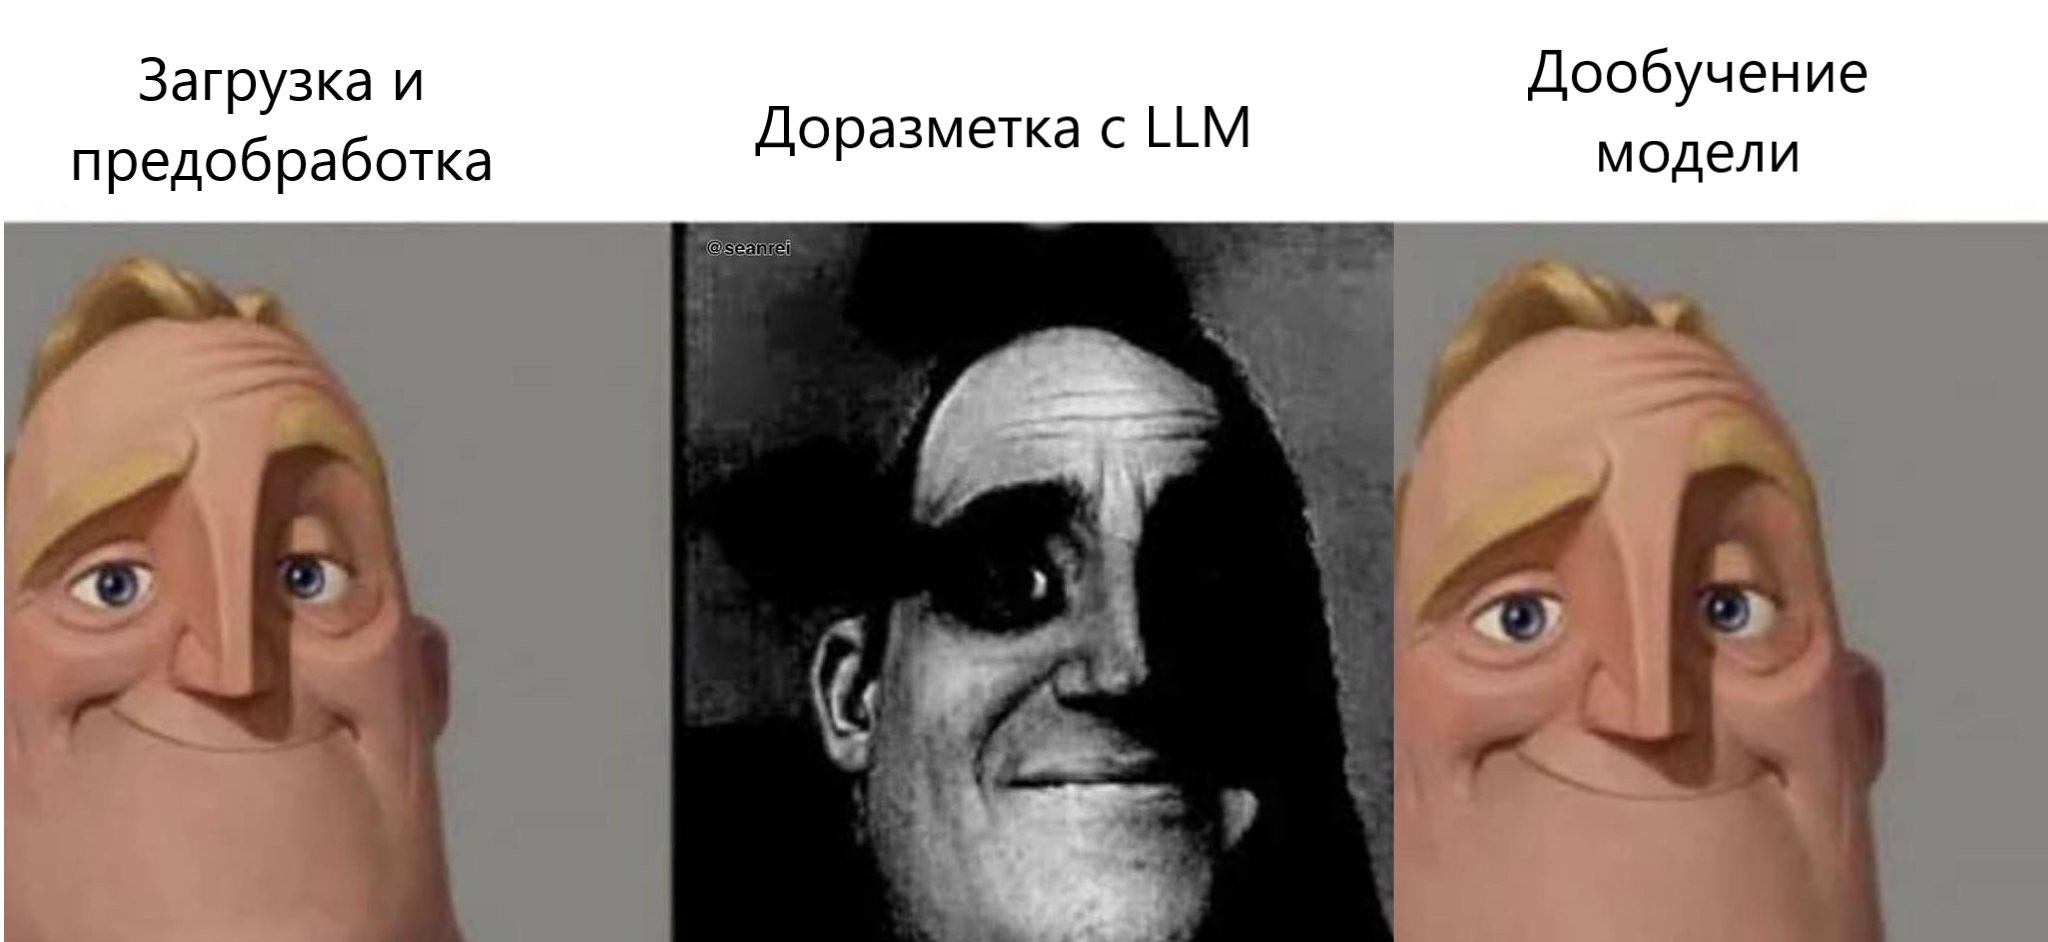